In [13]:
# Enable interactive plot
%matplotlib notebook
import sys
sys.path.insert(0, '/home/smoggy/Downloads/forces_pro_client/')  # On Windows, note the doubly-escaped backslashes
import forcespro
import numpy as np
import casadi
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.animation as animation

# system
dt = 0.1
target = np.array([50, 50, 0, 0])
num_agent = 5


A = np.array([[1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
B = np.array([[0.5*dt**2, 0],
            [0, 0.5*dt**2],
            [dt, 0],
            [0, dt]])

nx = 4
nu = 2
ns = 1

# MPC setup
N = 4
Q = np.eye(nx)
R = np.eye(nu)
lam = 500


umin = -40 * np.ones([nu])
umax = 40 * np.ones([nu])
xmin = np.array([-200, -200, -10, -10])
xmax = np.array([200, 200, 10, 10])

# FORCESPRO multistage form
# assume variable ordering z[i] = [si, ui, x_i+1] for i=0...N-1
model = forcespro.nlp.SymbolicModel(N)
model.nvar = ns+nu+nx  # number of stage variables
model.neq = nx   # number of equality constraints
model.nh = num_agent    # number of nonlinear inequality constraints
model.npar = 5*num_agent  # number of parameters


model.objective = lambda z: casadi.reshape(z[ns+nu:]-target,1,-1) @ Q @ casadi.vertcat(z[ns+nu:]-target) + lam*z[0]

model.lb = np.concatenate(([0]*ns, umin, xmin), 0)
model.ub = np.concatenate(([+float("inf")]*ns, umax, xmax), 0)

model.eq = lambda z: A @ casadi.reshape(z[ns+nu:],-1,1) + B @ casadi.reshape(z[ns:ns+nu],-1,1)

for i in range(N):
    def neq(z, p):
        p_reshaped = (p.reshape((5, -1))).T
        lis = [(z[ns+nu]-p_reshaped[j,0]-p_reshaped[j,3]*(i+5)*dt)**2 + (z[ns+nu+1]-p_reshaped[j,1]-p_reshaped[j,4]*(i+5)*dt)**2+z[0]-p_reshaped[j,2]**2 for j in range(num_agent)]
        return casadi.vertcat(lis[0], lis[1], lis[2], lis[3], lis[4])
        # return casadi.vertcat((z[3] - p[0] - p[2]*i*dt )**2 + (z[4] - p[1]- p[3]*i*dt)**2 + z[0] - agent_radius ** 2)
    # model.ineq[i] = lambda z, p: casadi.vertcat((z[3] - p[0] - p[3]*i*dt )**2 + (z[4] - p[1]- p[4]*i*dt)**2 + z[0] - p[2] ** 2)
#     model.ineq[i] = neq
    model.ineq
    model.hu[i] = [+float("inf")]*num_agent                 
    model.hl[i] = [0]*num_agent

model.E = np.concatenate([np.zeros((4, 3)), np.eye(4)], axis=1) 
  

model.xinitidx = range(3, nu + nx + 1)




# Generate FORCESPRO solver
# -------------------------

# set options
options = forcespro.CodeOptions()
options.printlevel = 0
options.overwrite = 1
options.nlp.bfgs_init = None
options.maxit = 2000

# generate code
solver = model.generate_solver(options)




This is FORCESPRO v6.0.1, a code generator for fast numerical optimization.
Copyright (C) embotech AG [support@embotech.com], 2013-2023. All rights reserved.
Using server https://forces.embotech.com.


Variables 3 through 6 in stage 0 will be eliminated. Please check your nonlinear inequality constraints to make sure they remain valid. To prevent variable elimination use codeoptions.noVariableElimination = 1.


Server is running version v6.0.1                        [OK]
Preparing data to be sent...                            [OK]
Generating and compiling code...                        [OK]
Code successfully generated in 15.99 sec.
Package downloaded to FORCES_NLP_solver.zip.
Extracting package...                                   [OK]

Code generation successfully completed. Happy solving!

Your downloaded files contain the following directories:
- include: C header files
- interface: Matlab, Simulink and Python interfaces for your solver on the host machine
- obj: solver object files for simulation on Linux host machine
- lib: solver library files for simulation on Linux host machine

Import the interface module FORCES_NLP_solver_py and type
    help(FORCES_NLP_solver_py)
for help on how to call the solver from a Python script.

 


<IPython.core.display.Javascript object>


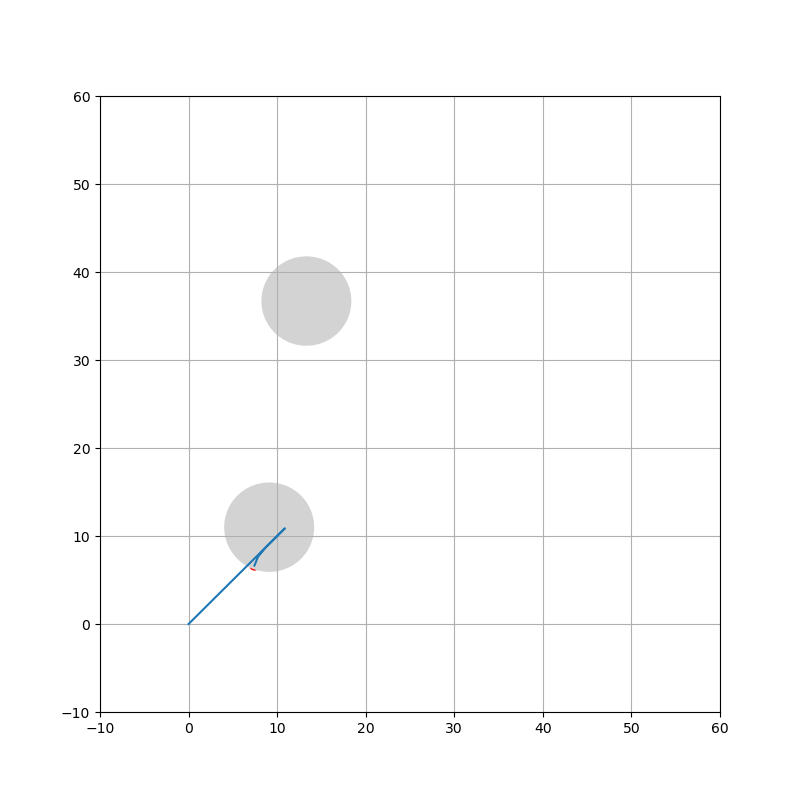

In [14]:
# Run simulation
# --------------
agent_list = np.array([[0, 50, 5, 7, -7], #px, py, r, vx, vy
                                           [0, 50, 0, 10, -10],
                                           [30, 30, 5, -11, -10],
                                           [0, 0, 0, 0, 0],
                                           [0, 0, 0, 0, 0]])
x1 = [0, 0, 0, 0]
kmax = 50
x = np.zeros((nx, kmax + 1))
x[:, 0] = x1
u = np.zeros((nu, kmax))
s = np.zeros((1, kmax))
problem = {}

solvetime = []
iters = []

for k in range(kmax):
    problem["xinit"] = x[:, k]

    params = []

    for agent in agent_list:
        params.extend([agent[0]+k*dt*agent[3], agent[1]+k*dt*agent[4], agent[2], agent[3], agent[4]])

    problem["all_parameters"] = np.tile(np.array(params), (model.N,))

    # call the solver
    solverout, exitflag, info = solver.solve(problem)
    if exitflag < 0:
        break

    s[0, k] = solverout["x1"][0]
    u[0, k] = solverout["x1"][1]
    u[1, k] = solverout["x1"][2]

    solvetime.append(info.solvetime)
    iters.append(info.it)
    c = np.concatenate([s[:, k], u[:, k], x[:, k]])
    a = model.eq(c)
    b = a.full()
    x[:, k + 1] = b.reshape(nx,)


fig = plt.figure(figsize=(8,8))
ax = plt.axes()
px = []
py = []
line, = plt.plot(px, py)
plt.grid()


def init():
    px.clear()
    py.clear()
    line.set_data(px, py)    
    return line,

def update(step):
    px.append(x[0, step])
    py.append(x[1, step])
    line.set_data(px, py)

    ax.patches = []
    drone = plt.Circle((x[0, step], x[1, step]), 0.5, color='r')
    ax.add_patch(drone)
    for agent in agent_list:
        circle = plt.Circle((agent[0] + step*dt*agent[3], agent[1] + step*dt*agent[4]), agent[2], color='lightgrey')
        ax.add_patch(circle)
        

    
    lb = min(min(px),min(py)-10,-10)
    ub = max(max(px),max(py)+10,60)
    ax.set_xlim(lb, ub)
    ax.set_ylim(lb, ub)
    return line, 


ani = animation.FuncAnimation(fig = fig, 
                              func = update,
                              init_func = init,
                              blit = False,
                              frames = x.shape[1], 
                              interval = 100)
plt.show()